In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score

In [16]:
# Load the dataset
file_path = r"C:\Users\Chukwuebuka\Documents\bank-additional-full.csv"
data = pd.read_csv(file_path, sep=';')  # semicolon is used as delimiter

In [3]:
# Display basic information about the dataset
data_info = data.info()
data_head = data.head()
data_info, data_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

(None,
    age        job  marital    education  default housing loan    contact  \
 0   56  housemaid  married     basic.4y       no      no   no  telephone   
 1   57   services  married  high.school  unknown      no   no  telephone   
 2   37   services  married  high.school       no     yes   no  telephone   
 3   40     admin.  married     basic.6y       no      no   no  telephone   
 4   56   services  married  high.school       no      no  yes  telephone   
 
   month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
 0   may         mon  ...         1    999         0  nonexistent          1.1   
 1   may         mon  ...         1    999         0  nonexistent          1.1   
 2   may         mon  ...         1    999         0  nonexistent          1.1   
 3   may         mon  ...         1    999         0  nonexistent          1.1   
 4   may         mon  ...         1    999         0  nonexistent          1.1   
 
    cons.price.idx  cons.conf.idx  

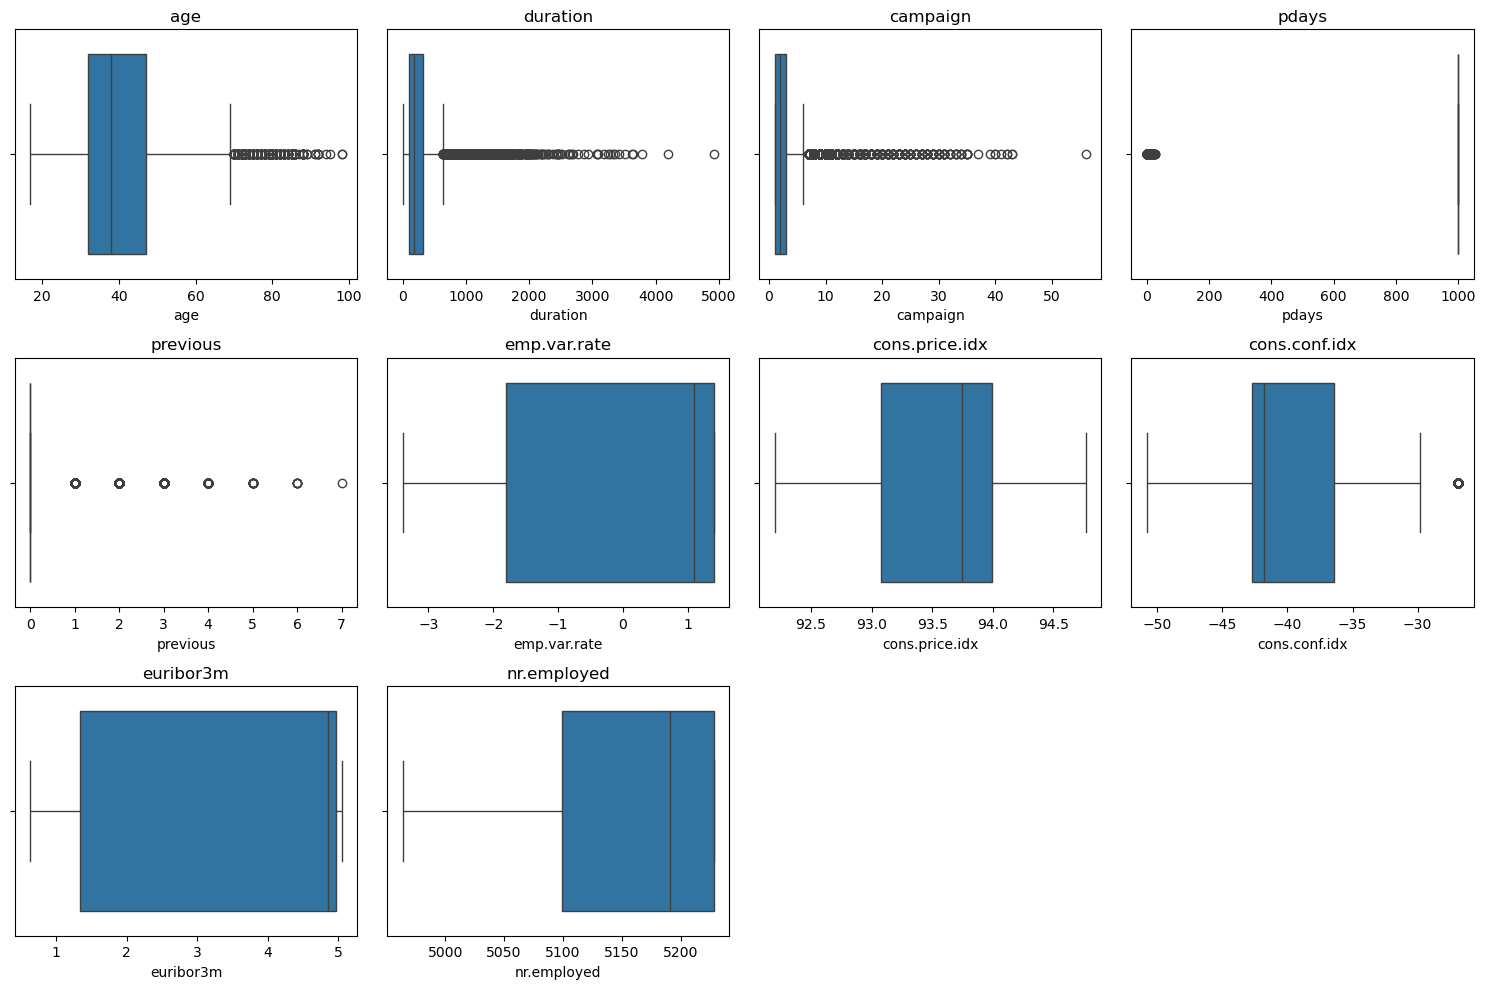

In [4]:
# Plot each numeric column to visualize outliers
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(x=data[col])
    plt.title(col)
plt.tight_layout()
plt.show()

# Detect and handle outliers
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Remove outliers from numeric columns
data = remove_outliers(data, numeric_columns)

In [5]:
# Encode categorical columns
data_encoded = data.copy()
label_encoders = {}

for column in data_encoded.select_dtypes(include='object').columns:
    if column != 'y':
        le = LabelEncoder()
        data_encoded[column] = le.fit_transform(data_encoded[column])
        label_encoders[column] = le

data_encoded['y'] = LabelEncoder().fit_transform(data_encoded['y'])

In [6]:
# Split the dataset
X = data_encoded.drop(columns='y')
y = data_encoded['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Hyperparameter tuning with GridSearchCV
param_grid = {
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': [None, 'balanced']
}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, error_score='raise')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

In [13]:
best_model

DecisionTreeClassifier(max_depth=10, max_features='sqrt', min_samples_split=20,
                       random_state=42)

In [12]:
# Predict with the best model
y_pred = best_model.predict(X_test)

# Calculate accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Display results
print("Best Model Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy)
report_df

Best Model Parameters: {'class_weight': None, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 20}
Accuracy: 0.983989614885331


,precision,recall,f1-score,support
0,0.984155,0.999779,0.991905,4535.00000
1,0.933333,0.160920,0.274510,87.00000
accuracy,0.983990,0.983990,0.983990,0.98399
macro avg,0.958744,0.580350,0.633208,4622.00000
weighted avg,0.983198,0.983990,0.978402,4622.00000


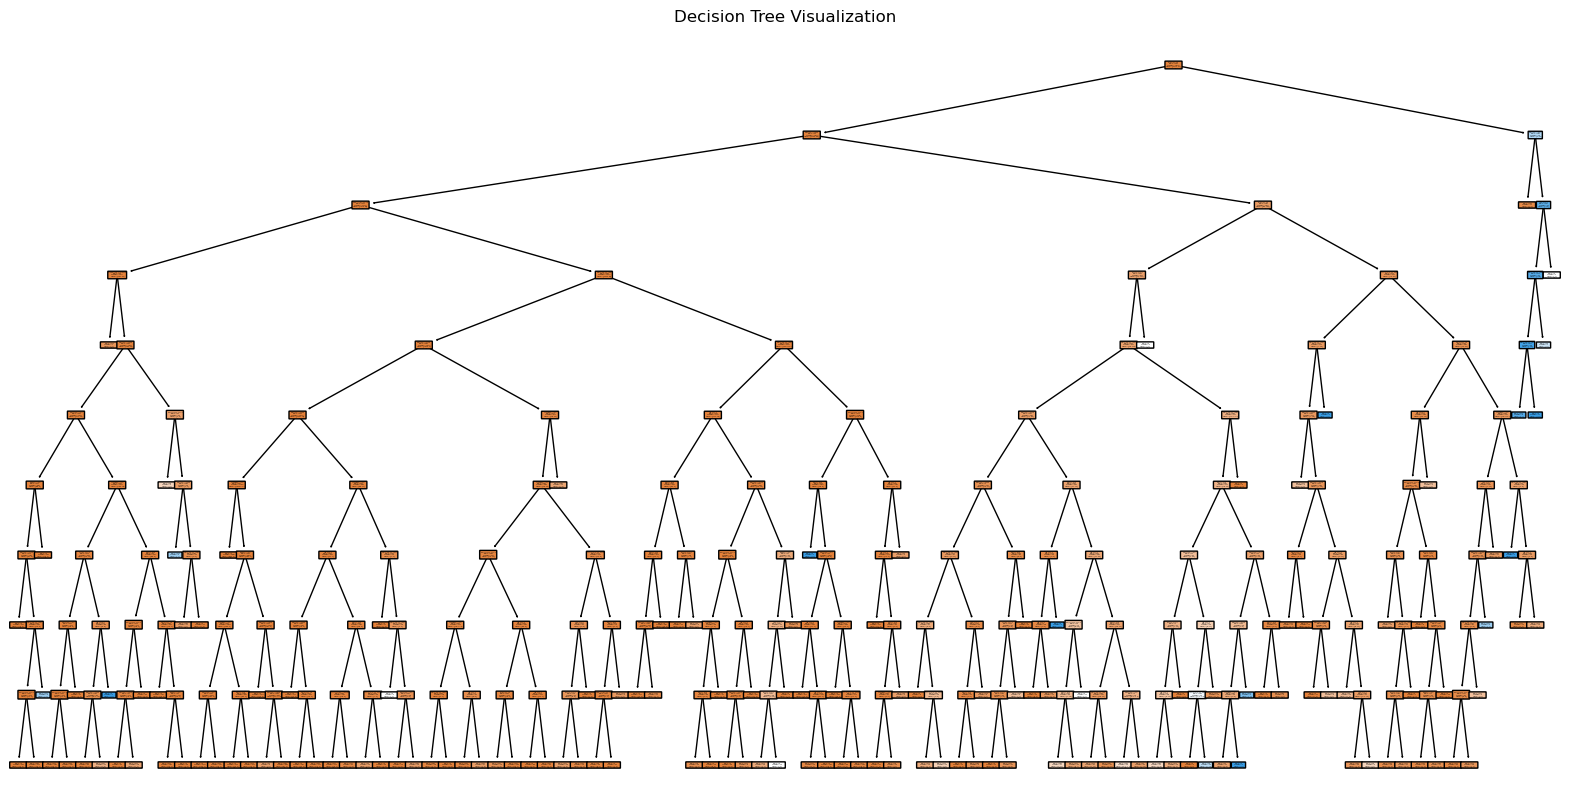

In [17]:
# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(best_model, filled=True, feature_names=X.columns, class_names=['Not Subscribed', 'Subscribed'], rounded=True)
plt.title("Decision Tree Visualization")
plt.show()